File for exploring bat species classification using unsupervised learning. Methods inspired by Guerrero et al. 2023. 
https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.14103

Notable differences:
1. segmentation (they used otsu thresholding, I used batdetect2 CNN)
    - for better detection, but probably takes too much computation
2. feature extraction (they compute LFCCs with specific params in a specific way, I use PyTorch's LFCC class out of the box)
    - temporary, for proof of concept
3. LFCC filtering (they keep all LFCCs, i only keep those of dim (1, 40, 2) so that they're all the same size) 
    - temporary, for proof of concept
4. clustering (they use LAMDA cluster, I use k-means clustern)
    - temporary, for proof of concept (note: LAMDA function unpopular and I could not find existing code)

In [ ]:
from tqdm import tqdm
from pydub import AudioSegment
import pandas as pd
import numpy as np
import torchaudio
from torchaudio import transforms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import sys
import glob

In [ ]:
sys.path.insert(0, os.path.abspath('../')) # for importing batdetect2

In [ ]:
from batdetect2 import api # for pulse detection

# helper functions

In [35]:
def detect_pulses(filename, audio_dir, output_dir):
    """
    Given directory and filename, create a csv with
    star time, end time, and detection probability.
    
    detections:
    [{
        'start_time': 0.0015,
        'end_time': 0.0318,
        'low_freq': 68437,
        'high_freq': 79180,
        'class': 'Rhinolophus ferrumequinum',
        'class_prob': 0.151,
        'det_prob': 0.152,
        'individual': '-1',
        'event': 'Echolocation'
    },...]
    """   
    audio_file = os.path.join(audio_dir, filename)
    audio = api.load_audio(audio_file)
    detections, features, spec = api.process_audio(audio)

    start_times = [det['start_time'] for det in detections]
    end_times = [det['end_time'] for det in detections]
    det_probs = [det['det_prob'] for det in detections]

    df = pd.DataFrame(data={'start_times':start_times, 'end_times':end_times, 'det_probs':det_probs})
    df.to_csv(output_dir + filename[:-3] + 'csv', index=False)

In [36]:
def slice_audio(filename, det_dir, audio_dir, output_dir, cutoff_prob):
    """
    Given a .csv file of detections (start_time, end_time, det_prob),
    save new audio files from start->end time of detections that meet
    cutoff probability.
    """
    audio_file = os.path.join(audio_dir, filename[:-3] + 'wav')
    det_file = os.path.join(det_dir, filename)
    
    audio = AudioSegment.from_file(audio_file, format="wav")
    df = pd.read_csv(det_file)
    
    cutoff_df = df.loc[df['det_probs'] >= cutoff_prob]

    for index, row in cutoff_df.iterrows():
        start_time, end_time = row['start_times'] * 1000, row['end_times'] * 1000 # conver to milliseconds
        audio_splice = audio[start_time:end_time]
        audio_splice.export(output_dir + filename[:-4] + '-' + str(index) + '.wav', format='wav')

In [37]:
def compute_lfcc(audio_file):
    """
    Compute linear frequency cepstral coefficient of an audio file
    """
    waveform, sample_rate = torchaudio.load(audio_file, normalize=True)
    transform = transforms.LFCC(
        sample_rate=sample_rate,
        # n_lfcc=13,
        # speckwargs={"n_fft": 400, "hop_length": 160, "center": False},
    )

    lfcc = transform(waveform)
    return lfcc

In [261]:
def prepare_data(directory):
    """
    Returns
    X: LFCCS (num detections, LFCC dim flattened)
    Y: species labels (num detections, 1)
    """
    X = []
    Y = []

    for filename in os.listdir(directory):
        audio_file = os.path.join(directory, filename)
        
        try:
            lfcc = compute_lfcc2(audio_file)    
        except:
            continue
        
        if lfcc.shape[2] == 2: # lfccs not all the same shape, do this to filter for now
            X.append(lfcc)
            
            # get species code from file name
            species_idx = audio_file.index('-') + 1
            Y.append(audio_file[species_idx:species_idx + 4])

    X = np.concatenate([x for x in X])
    X = X.reshape(X.shape[0], -1)
    Y = np.array(Y)
    
    return X, Y

In [42]:
def reduce_dims(X):
    X_embedded = TSNE(
        n_components=2,
        learning_rate='auto',
        init='random',
        perplexity=10,
        n_iter=3000
     ).fit_transform(X)

    return X_embedded

In [45]:
def assign_clusters(km_labels, gt_labels):
    """
    Given both the kmeans and ground truth labels after
    kmeans clustering, assign each cluster a species
    label based on popular vote
    """
    cluster_votes = {}

    for i, label in enumerate(km_labels):
        if label not in cluster_votes:
            cluster_votes[label] = {species : 0 for species in np.unique(gt_labels)}
        species = Y[i]   
        cluster_votes[label][species] += 1

    cluster_assigns = {}    

    for cluster, votes in cluster_votes.items():
        cluster_assigns[cluster] = max(votes, key=votes.get)

    return cluster_assigns

In [76]:
def predict(filename, det_dir, audio_dir, output_dir, cutoff_prob, cluster_assigns):
    """
    Given an audio file, predict the species by using kmeans.predict on
    each call pulse and taking a popular vote.
    """
    output_files = glob.glob(output_dir + '/*')
    for f in output_files:
        os.remove(f)

    slice_audio(filename, det_dir, audio_dir, output_dir, cutoff_prob)
    X, Y = prepare_data(output_dir)
    
    X = reduce_dims(X)
    
    prediction = kmeans.predict(X)
    return cluster_assigns[max(prediction)]

In [119]:
def predict_by_pulse(filename, det_dir, audio_dir, output_dir, cutoff_prob, cluster_assigns):
    """
    Given an audio file, predict the species by using kmeans.predict on
    each call pulse
    """
    output_files = glob.glob(output_dir + '/*')
    for f in output_files:
        os.remove(f)

    slice_audio(filename, det_dir, audio_dir, output_dir, cutoff_prob)
    X, Y = prepare_data(output_dir)
    
    X = reduce_dims(X)
    
    predictions = kmeans.predict(X)
    return [cluster_assigns[p] for p in predictions]

In [148]:
def label_to_color(Y):
    labels = []
    for species in Y:
        if species == "Coto": labels.append(0)
        if species == "Laci": labels.append(1)
        if species == "Anpa": labels.append(2)
    return np.array(labels)

# Using implementation on JRBP dataset

In [ ]:
# get detection times for sample datset of 30 recordings
audio_dir = '../test_audio'
det_dir = './detections/'

for filename in tqdm(os.listdir(audio_dir)):
    detect_pulses(filename, audio_dir, det_dir)

In [305]:
# create new wav files based on detections collected above
audio_dir = '../test_audio'
det_dir = './detections/'
audio_slice_dir = './audio_slices/'
cutoff_prob = 0.4

for filename in tqdm(os.listdir(det_dir)):
    slice_audio(filename, det_dir, audio_dir, audio_slice_dir, cutoff_prob)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]


In [306]:
# create dataset for clustering
audio_slice_dir = './audio_slices/'
X, Y = prepare_data(audio_slice_dir)

ValueError: need at least one array to concatenate

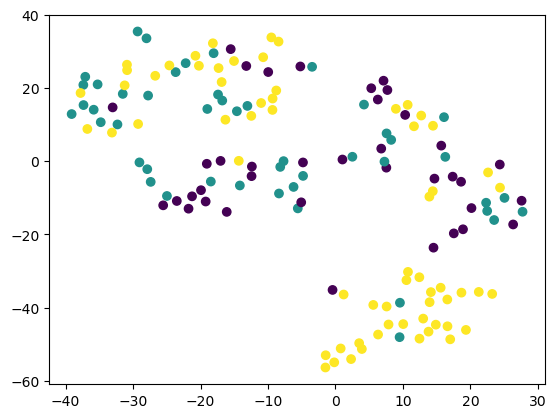

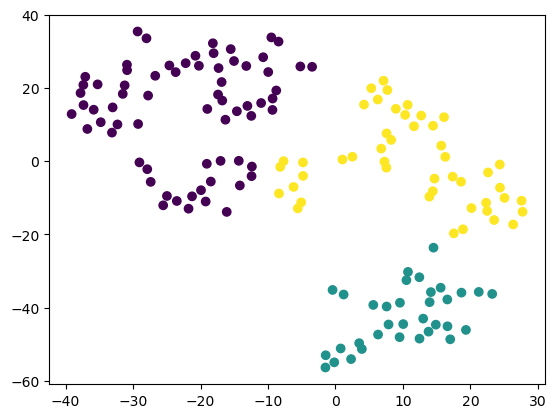

In [264]:
# run kmeans
# X = reduce_dims(X)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plt.scatter(X[:,0], X[:,1], c=label_to_color(Y))
plt.show()

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()

In [265]:
# assign clusters a species
cluster_assigns = assign_clusters(kmeans.labels_, Y)
cluster_assigns

{2: 'Coto', 0: 'Laci', 1: 'Anpa'}

In [266]:
# run single popular vote prediction
filename = 'barn1_D20220723T000059m428-Coto.csv'
det_dir = './detections/'
audio_dir = '../test_audio/'
output_dir = './prediction_slices/'
cutoff_prob = 0.4

predict(filename, det_dir, audio_dir, output_dir, cutoff_prob, cluster_assigns)

'Coto'

In [267]:
# run popular prediction on all files
predictions = []
for filename in os.listdir(det_dir):
    try:
        y_hat = predict(filename, det_dir, audio_dir, output_dir, cutoff_prob, cluster_assigns)
        predictions.append(y_hat)
    except:
        predictions.append("ERROR") # current problem when there's only 1 valid slice
    
predictions

['Coto',
 'Coto',
 'Coto',
 'ERROR',
 'Coto',
 'Anpa',
 'Coto',
 'Coto',
 'ERROR',
 'Coto',
 'Coto',
 'Coto',
 'Coto',
 'Coto',
 'Coto',
 'Coto',
 'Anpa',
 'Coto',
 'Coto',
 'ERROR',
 'Coto',
 'Laci',
 'Coto',
 'Anpa',
 'Coto',
 'ERROR',
 'Coto',
 'Coto',
 'Anpa',
 'Coto']

In [268]:
# get popular vote accuracy
# Ex: num_predicted_correctly / num_present
n_samples = 0
n_correct = 0

for i, filename in enumerate(os.listdir(det_dir)):
    if predictions[i] == "ERROR": # current error for when only one pulse is detected, skip for now
        continue
    
    n_samples += 1
    if predictions[i] == filename[-8:-4]:
        n_correct += 1

round(n_correct / n_samples * 100, 3)

30.769

In [269]:
# run single vote prediction
filename = 'barn1_D20220723T000059m428-Coto.csv'
det_dir = './detections/'
audio_dir = '../test_audio/'
output_dir = './prediction_slices/'
cutoff_prob = 0.4

predict_by_pulse(filename, det_dir, audio_dir, output_dir, cutoff_prob, cluster_assigns)

['Laci', 'Coto', 'Anpa', 'Anpa', 'Laci']

In [270]:
# run prediction on all files
predictions = []
for filename in os.listdir(det_dir):
    try:
        y_hat = predict_by_pulse(filename, det_dir, audio_dir, output_dir, cutoff_prob, cluster_assigns)
        predictions.append(y_hat)
    except:
        predictions.append("ERROR") # current problem when there's only 1 valid slice
        
predictions

[['Laci', 'Anpa', 'Coto', 'Laci', 'Anpa'],
 ['Anpa', 'Coto', 'Laci', 'Coto', 'Laci'],
 ['Laci', 'Coto', 'Anpa', 'Anpa'],
 'ERROR',
 ['Anpa', 'Coto', 'Anpa'],
 ['Laci', 'Coto'],
 ['Laci', 'Laci', 'Anpa'],
 ['Laci', 'Anpa', 'Laci'],
 'ERROR',
 ['Laci', 'Coto', 'Coto', 'Coto'],
 ['Laci', 'Laci', 'Coto', 'Coto', 'Laci', 'Anpa', 'Coto', 'Laci', 'Anpa'],
 ['Laci', 'Coto', 'Coto', 'Laci', 'Laci', 'Laci', 'Anpa', 'Anpa'],
 ['Anpa', 'Laci', 'Laci', 'Coto', 'Laci', 'Coto'],
 ['Laci', 'Laci', 'Laci', 'Anpa', 'Coto'],
 ['Anpa', 'Coto'],
 ['Laci',
  'Laci',
  'Laci',
  'Laci',
  'Anpa',
  'Laci',
  'Anpa',
  'Laci',
  'Anpa',
  'Anpa',
  'Coto',
  'Laci',
  'Laci',
  'Laci',
  'Laci',
  'Laci',
  'Coto',
  'Laci'],
 ['Coto', 'Anpa', 'Laci'],
 ['Laci', 'Coto', 'Anpa'],
 ['Anpa', 'Anpa', 'Laci', 'Laci', 'Coto', 'Coto'],
 'ERROR',
 ['Laci', 'Coto', 'Anpa', 'Laci'],
 ['Coto',
  'Coto',
  'Laci',
  'Coto',
  'Laci',
  'Coto',
  'Coto',
  'Coto',
  'Coto',
  'Coto',
  'Laci',
  'Laci',
  'Laci',
  'Coto'

In [271]:
HR_by_species = {}

for test_species in ["Coto", "Anpa", "Laci"]:
    n_samples = 0
    n_correct = 0

    for i, filename in enumerate(os.listdir(det_dir)):
        true_species = filename[-8:-4] 
        
        if predictions[i] == "ERROR": # current error for when only one pulse is detected, skip for now
            continue
            
        if true_species != test_species:
            continue

        n_samples += 1
        if true_species in predictions[i]:
            n_correct += 1

        HR = round(n_correct / n_samples * 100, 3)
        HR_by_species[test_species] = HR
        
HR_by_species

{'Coto': 77.778, 'Anpa': 88.889, 'Laci': 100.0}

In [272]:
# false positive rate
# FP / FP + TN
# for a specific species
# over each audio file
# num times predict wrong / num times predict wrong + num times didn't predict correctly

FPR_by_species = {}

for test_species in ["Coto", "Anpa", "Laci"]:
    FP = 0
    TN = 0

    for i, filename in enumerate(os.listdir(det_dir)):
        true_species = filename[-8:-4] # get species name from wav file name

        if predictions[i] == "ERROR": # current error for when only one pulse is detected, skip for now
            continue

        if test_species in predictions[i] and test_species != true_species:
            FP += 1

        if test_species not in predictions[i] and test_species != true_species:
            TN += 1
        
    FPR = FP / (FP + TN)
    FPR = round(FPR, 3)
    
    FPR_by_species[test_species] = FPR
    
FPR_by_species

{'Coto': 0.882, 'Anpa': 0.824, 'Laci': 0.889}

# Tests

In [302]:
def compute_lfcc2(audio_file):
    """
    Compute linear frequency cepstral coefficient of an audio file
    """
    waveform, sample_rate = torchaudio.load(audio_file, normalize=True)
    transform = transforms.LFCC(
        sample_rate=sample_rate,
        n_lfcc=24,
        log_lf=True,
        dct_type=dct.dct
        # n_lfcc=13,
        # speckwargs={"n_fft": 400, "hop_length": 160, "center": False},
    )

    lfcc = transform(waveform)
    return lfcc

In [297]:
import torch_dct as dct

In [296]:
!pip install torch_dct

In [303]:
audio_dir = './audio_slices'
files = os.listdir(audio_dir)
path = os.path.join(audio_dir, files[12])

waveform, sample_rate = torchaudio.load(path, normalize=True)
output = compute_lfcc2(path)

ValueError: DCT type not supported: <function dct at 0x7ff46b6d99d0>

In [283]:
waveform.shape

torch.Size([1, 208])

In [284]:
output.shape

torch.Size([1, 24, 2])

In [ ]:
ns = [2, 3]
perplexities = [5, 10, 15]
iters = [1000, 2000, 3000]

for n in ns:
    for p in perplexities:
        for i in iters:
            print('n_components: ', n)
            print('perplexity: ', p)
            print('n_iters: ', i)
            
            X_embedded = TSNE(n_components=n,
                                learning_rate='auto',
                                init='random',
                                perplexity=p,
                                n_iter=i
                             ).fit_transform(X)
            
            fig = px.scatter(X_embedded, x=0, y=1, color=Y)
            fig.show()

In [ ]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_embedded)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [47]:
filename = 'barn1_D20220723T000059m428-Coto.csv'
det_dir = './detections/'
audio_dir = '../test_audio/'
output_dir = './prediction_slices/'
cutoff_prob = 0.4

predict(filename, det_dir, audio_dir, output_dir, cutoff_prob)

TypeError: predict() missing 1 required positional argument: 'cluster_assigns'

In [ ]:
def label_to_color(Y):
    labels = []
    for species in Y:
        if species == "Coto": labels.append(0)
        if species == "Laci": labels.append(1)
        if species == "Anpa": labels.append(2)
    return np.array(labels)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=kmeans.labels_)
plt.show()

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=label_to_marker(Y))
plt.show()

In [ ]:
os.getcwd()

In [ ]:
Y